In [1]:
import tensorflow as tf
from keras.layers import LSTM, Dropout, Flatten, Dense, MaxPooling2D, Embedding, Bidirectional, Input
from keras.models import Sequential, Model
import pickle 
import numpy as np
from keras.layers import Conv2D, Add, ConvLSTM2D, Reshape, BatchNormalization
from keras.optimizers import Adam, schedules

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.70)

tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
with open('processed_data/X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
    
with open('processed_data/X_valid.pickle', 'rb') as f:
    X_valid = pickle.load(f)

with open('processed_data/X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)

In [4]:
with open('processed_data/y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with open('processed_data/y_valid.pickle', 'rb') as f:
    y_valid = pickle.load(f)

with open('processed_data/y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)


In [5]:
X_train.shape

(15373, 128, 513, 1)

In [6]:
models_input = Input(shape=X_train[0].shape)

In [7]:
cnn_model = Sequential()
cnn_model.add(models_input)

cnn_model.add(Conv2D(filters=16, kernel_size=2, padding="same", strides=(2,2), activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=32, kernel_size=3, padding="same", strides=(2,2), activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))

cnn_model.add(Conv2D(filters=64, kernel_size=3, padding="same", strides=(2,2), activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=128, kernel_size=4, padding="same", activation="relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=2))

cnn_model.add(Conv2D(filters=64, kernel_size=4, padding="same", activation="relu"))
cnn_model.add(BatchNormalization())

cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 257, 16)       80        
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 257, 16)       64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 128, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 128, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 32)         0

In [8]:
lstm_model = Sequential()

lstm_model.add(models_input)
lstm_model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))
lstm_model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))
lstm_model.add(Reshape((128, 128)))

lstm_model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
lstm_model.add(Bidirectional(LSTM(units = 128)))

lstm_model.add(Flatten())
lstm_model.add(Dropout(0.5))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_4 (MaxPooling2 (None, 128, 256, 1)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 1)       0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [9]:
mergedModel = Add()([cnn_model.output, lstm_model.output])
mergedModel = Dense(10, activation='softmax')(mergedModel)

model = tf.keras.models.Model(inputs=models_input, outputs=mergedModel)

opt = Adam(learning_rate=0.005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 513, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 257, 16)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 257, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 128, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='combined_model.weights.best.hdf5', verbose=1, save_best_only=True)

hist = model.fit(X_train, y_train, 
                     batch_size=32,
                     epochs=70,
                     validation_data=(X_valid, y_valid),
                     callbacks=[checkpointer],
                     verbose=1,
                     shuffle=True)

Epoch 1/70
481/481 [==============================] - 21s 33ms/step - loss: 1.8065 - accuracy: 0.3878 - val_loss: 1.7000 - val_accuracy: 0.4412

Epoch 00001: val_loss improved from inf to 1.69996, saving model to combined_model_5.weights.best.hdf5
Epoch 2/70
481/481 [==============================] - 15s 31ms/step - loss: 1.1916 - accuracy: 0.5791 - val_loss: 1.2311 - val_accuracy: 0.5617

Epoch 00002: val_loss improved from 1.69996 to 1.23107, saving model to combined_model_5.weights.best.hdf5
Epoch 3/70
481/481 [==============================] - 15s 31ms/step - loss: 1.0577 - accuracy: 0.6275 - val_loss: 1.0755 - val_accuracy: 0.6214

Epoch 00003: val_loss improved from 1.23107 to 1.07551, saving model to combined_model_5.weights.best.hdf5
Epoch 4/70
481/481 [==============================] - 15s 31ms/step - loss: 0.9651 - accuracy: 0.6557 - val_loss: 0.9034 - val_accuracy: 0.6758

Epoch 00004: val_loss improved from 1.07551 to 0.90338, saving model to combined_model_5.weights.best.h

481/481 [==============================] - 15s 31ms/step - loss: 0.2535 - accuracy: 0.9088 - val_loss: 0.5432 - val_accuracy: 0.8291

Epoch 00039: val_loss did not improve from 0.46701
Epoch 40/70
481/481 [==============================] - 15s 31ms/step - loss: 0.2459 - accuracy: 0.9152 - val_loss: 0.6557 - val_accuracy: 0.8198

Epoch 00040: val_loss did not improve from 0.46701
Epoch 41/70
481/481 [==============================] - 16s 32ms/step - loss: 0.2441 - accuracy: 0.9161 - val_loss: 0.4742 - val_accuracy: 0.8566

Epoch 00041: val_loss did not improve from 0.46701
Epoch 42/70
481/481 [==============================] - 15s 32ms/step - loss: 0.2429 - accuracy: 0.9158 - val_loss: 0.5113 - val_accuracy: 0.8461

Epoch 00042: val_loss did not improve from 0.46701
Epoch 43/70
481/481 [==============================] - 15s 32ms/step - loss: 0.2323 - accuracy: 0.9182 - val_loss: 0.5736 - val_accuracy: 0.8373

Epoch 00043: val_loss did not improve from 0.46701
Epoch 44/70
481/481 [======

In [11]:
model.evaluate(X_test, y_test)

60/60 [==============================] - 1s 12ms/step - loss: 0.5524 - accuracy: 0.8504


[0.5524124503135681, 0.8504475951194763]

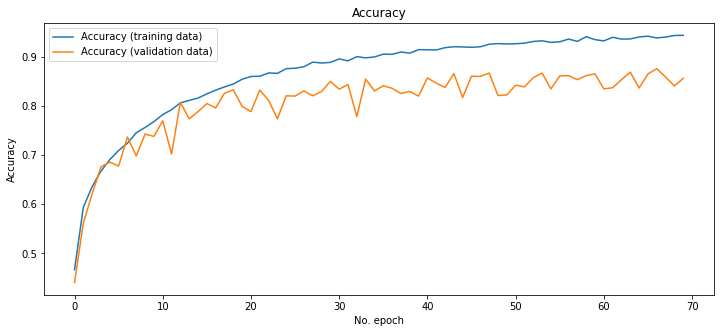

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.plot(hist.history['accuracy'], label='Accuracy (training data)')
plt.plot(hist.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="best")
plt.show()

In [13]:
# # serialize model to JSON
model_json = model.to_json()
with open("combined_model.json", "w") as json_file:
    json_file.write(model_json)

# # serialize weights to HDF5
model.save_weights("combined_model_weights.h5")
print("Saved model to disk")

Saved model to disk
